In [1]:
%load_ext autoreload
%autoreload 2

In [29]:
import os
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt

In [3]:
droot = '/glade/scratch/mclong/TM5-from-Andy'
path = f'{droot}/molefrac_glb100x100_199404170000_199404180000.nc'
ds = xr.open_dataset(path)
ds

<xarray.Dataset>
Dimensions:              (time: 1, calendar_components: 6, longitude: 360, latitude: 180, level: 137, boundary: 138)
Coordinates:
  * time                 (time) datetime64[ns] 2024-04-16T12:00:00
  * calendar_components  (calendar_components) int32 1 2 3 4 5 6
  * longitude            (longitude) float64 -180.0 -179.0 ... 178.0 179.0
  * latitude             (latitude) float64 -90.0 -89.0 -88.0 ... 87.0 88.0 89.0
  * level                (level) int32 1 2 3 4 5 6 7 ... 132 133 134 135 136 137
  * boundary             (boundary) int32 1 2 3 4 5 6 ... 134 135 136 137 138
Data variables: (12/22)
    decimal_date         (time) float64 ...
    time_components      (time, calendar_components) int32 ...
    apo_jena             (time, level, latitude, longitude) float32 ...
    o2_cesm              (time, level, latitude, longitude) float32 ...
    co2_cesm             (time, level, latitude, longitude) float32 ...
    n2_cesm              (time, level, latitude, longitude) float32 ...
    ...                   ...
    blh                  (time, latitude, longitude) float32 ...
    temperature          (time, level, latitude, longitude) float32 ...
    specific_humidity    (time, level, latitude, longitude) float32 ...
    air_mass             (time, level, latitude, longitude) float32 ...
    u                    (time, level, latitude, longitude) float32 ...
    v                    (time, level, latitude, longitude) float32 ...
Attributes:
    notes:        This file contains CarbonTracker mole fractions averaged ov...
    disclaimer:   CarbonTracker is an open product of the NOAA Earth System R...
    email:        carbontracker.team@noaa.gov
    url:          https://carbontracker.noaa.gov
    institution:  NOAA Global Monitoring Laboratory
    conventions:  CF-1.5
    history:      Created 2022-05-17 12:23:45 UTC by /work/noaa/co2/andy/Proj...
    source:       CarbonTracker

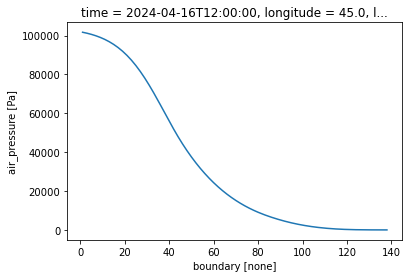

In [106]:
ds.pressure.sel(longitude=45, latitude=45, method='nearest').plot()

pressure
surface: range = 51995.49, 104449.70
zonal mean: range = 0.00, 101783.99

apo_jena
surface: range = nan, nan
zonal mean: range = 400.00, 400.00

co2_cesm
surface: range = -999512391578203462631864930737848320.00, 995016114127356447209093718012329984.00
zonal mean: range = -972283652826113666409403713606123520.00, 960043218630309883308551547455012864.00

co2_gridfed
surface: range = nan, nan
zonal mean: range = 3615.81, 20463.47

co2_oco2mip
surface: range = nan, nan
zonal mean: range = 400.00, 400.00

co2_somffn
surface: range = -997803043971958209548284220009349120.00, 996400705495455730772878492088401920.00
zonal mean: range = -986556764759383415355555843347054592.00, 941684548040667065265713136827105280.00

n2_cesm
surface: range = -990175986451197524561166524542353408.00, 969448156117890660031268369167548416.00
zonal mean: range = -937396799113557593579488131778871296.00, 964671965568880748703779165665492992.00

n2_era
surface: range = -999278985411436439893314350260158464

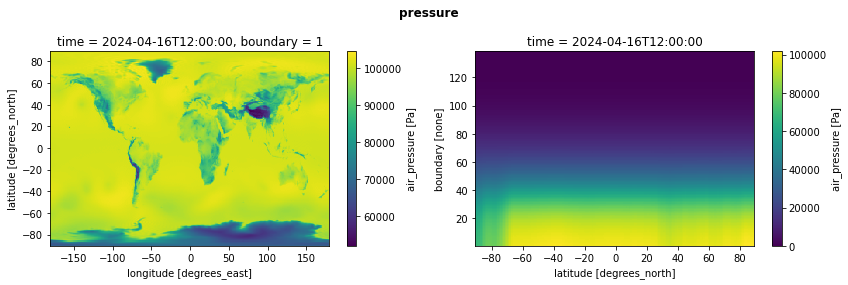

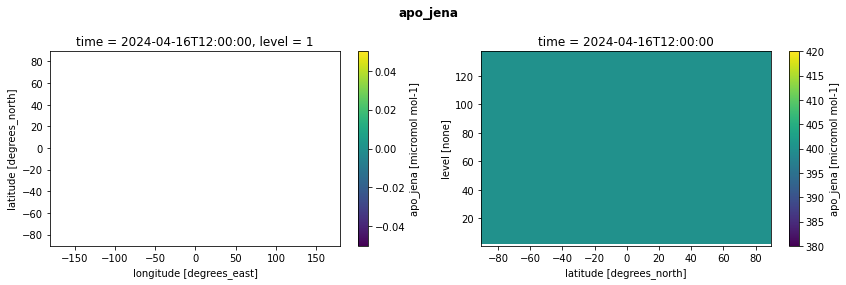

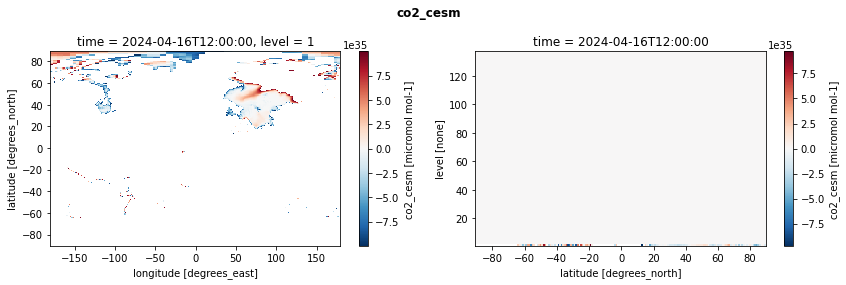

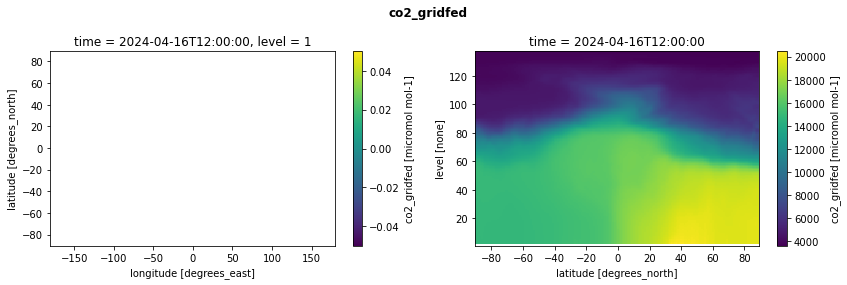

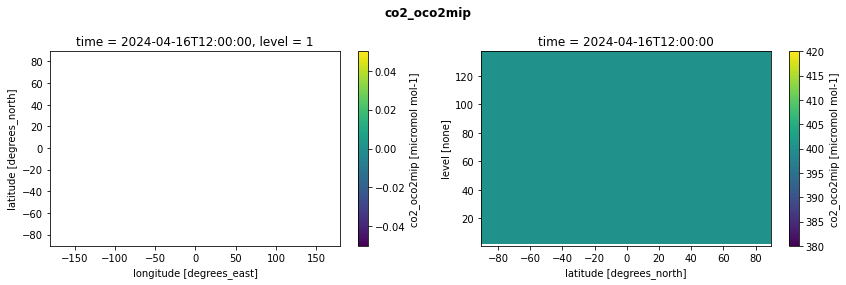

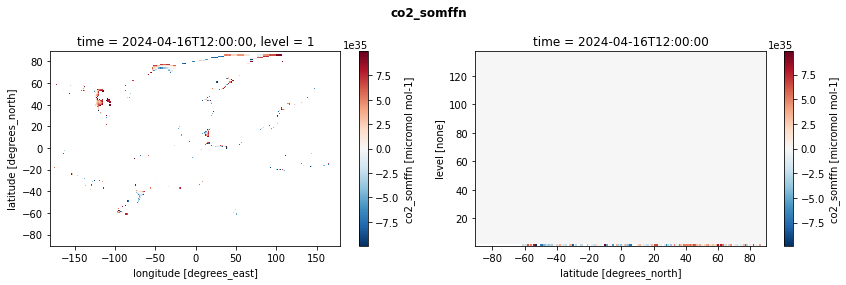

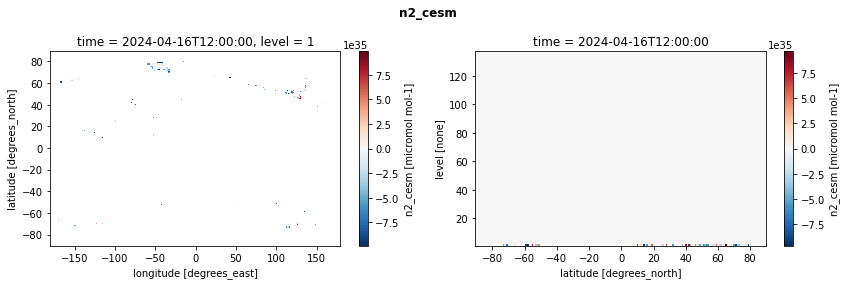

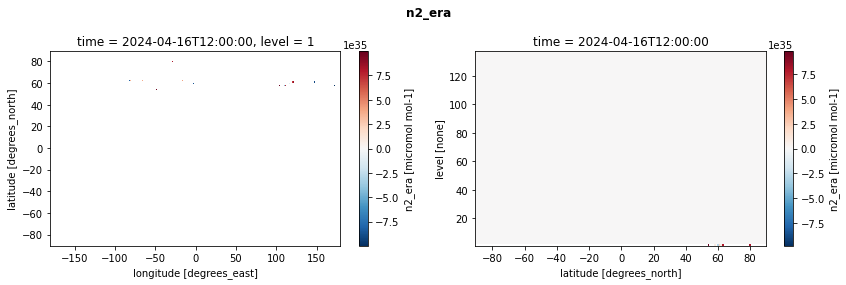

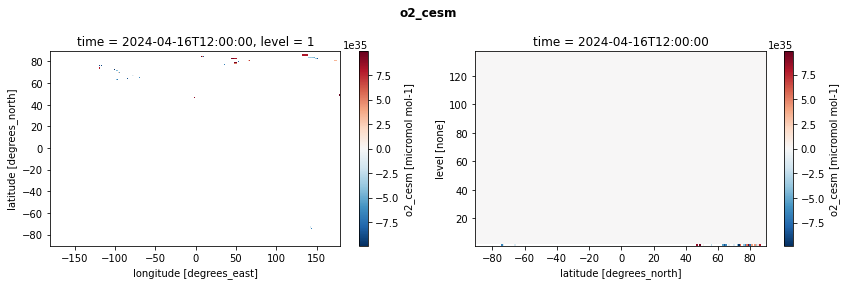

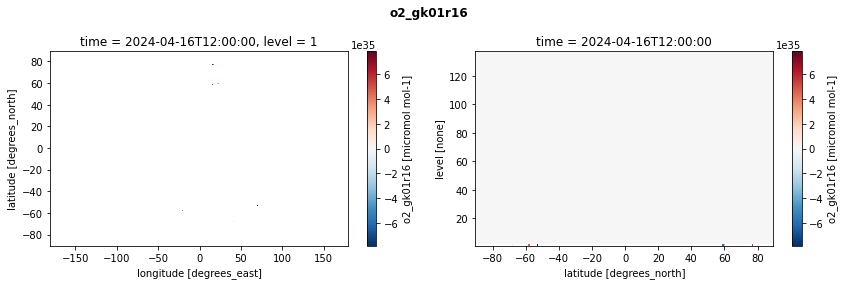

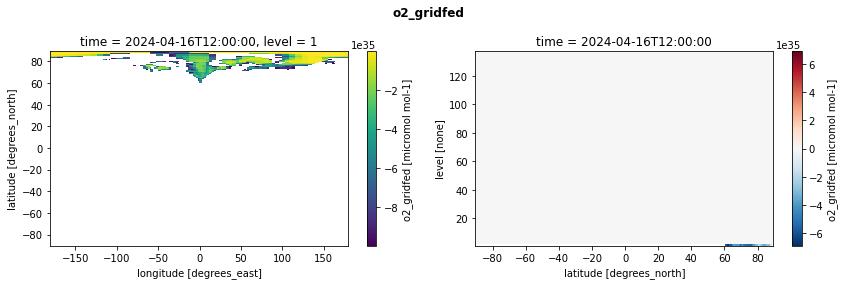

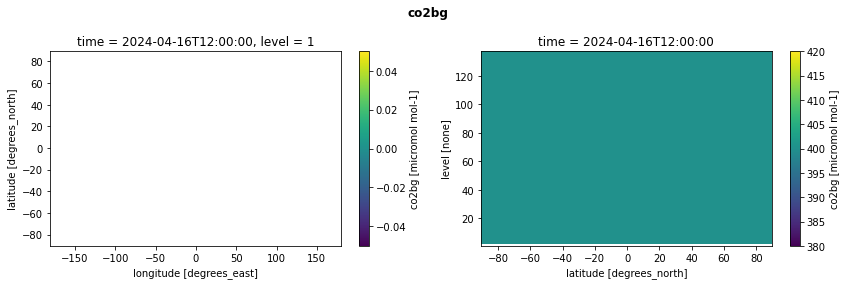

In [114]:
sno_vars = [
    'apo_jena', 
    'co2_cesm', 
    'co2_gridfed', 
    'co2_oco2mip', 
    'co2_somffn', 
    'n2_cesm', 
    'n2_era', 
    'o2_cesm', 
    'o2_gk01r16', 
    'o2_gridfed',
]
for v in ['pressure'] + sno_vars + ['co2bg']:
    
    if v not in ds:
        print(f'missing {v}')
        continue
    
    if v in sno_vars:            
        assert ds[v].units == 'micromol mol-1'
    
    print(v)
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))        
       
    if 'level' in ds[v].dims:
        isel = dict(level=0)
    elif 'boundary' in ds[v].dims:
        isel = dict(boundary=0)

    with xr.set_options(keep_attrs=True):    
        surface = ds[v].where(np.abs(ds[v]) < 1.0e30).isel(**isel)
        zonal_mean = ds[v].where(np.abs(ds[v]) < 1.0e30).mean('longitude')
    
    if ds[v].units == 'micromol mol-1':
        surface *= 1e6
        zonal_mean *= 1e6
        
    vmin, vmax = np.percentile(surface.values, [2.5, 97.5])
    
    surface.plot(ax=axs[0]) #, vmin=vmin, vmax=vmax)    
    print(f'surface: range = {surface.min().values:0.2f}, {surface.max().values:0.2f}')

    vmin, vmax = np.percentile(zonal_mean.values, [2.5, 97.5])
    zonal_mean.plot(ax=axs[1]) #, vmin=vmin, vmax=vmax)
    print(f'zonal mean: range = {zonal_mean.min().values:0.2f}, {zonal_mean.max().values:0.2f}')
    
    plt.suptitle(v, fontweight='bold')
    plt.tight_layout();
    print()

## Interpolate model to ObsPack locations


In [31]:
obspack_dir = "/glade/work/mclong/sno-analysis/obspack_co2_1_GLOBALVIEWplus_v7.0_2021-08-18/data/nc"
surface_files = [
    f"{obspack_dir}/co2_alt_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_brw_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_cba_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_cgo_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_kum_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_ljo_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_mlo_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_psa_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_smo_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_spo_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_gould_shipboard-insitu_1_allvalid.nc",
]

stns = []
dsets_stn = {}
for f in surface_files:
    stn = os.path.basename(f).split('_')[1]
    stns.append(stn)
    with xr.open_dataset(f) as dsi:
        dsets_stn[stn] = dsi.load() 

In [42]:
import esmf_tools
from functools import partial

interp_points = partial(
    esmf_tools.esmf_interp_points,
    ds_in=ds[sno_vars].isel(level=-1),
    lon_field_name='longitude',
    lat_field_name='latitude',
)

gould_lat_bin_e = np.arange(-66, -54, 2)
gould_lat_bin_c = np.vstack((gould_lat_bin_e[:-1], gould_lat_bin_e[1:])).mean(axis=0)


dsets_model = {}
for key, dsi in dsets_stn.items():
    if key == 'gould':        
        ndx = np.where(dsi.latitude < -40)[0]
        dsii = dsi.isel(obs=ndx)
        dsii = dsii.groupby_bins(dsii.latitude, gould_lat_bin_e).mean()
        for i, (lon, lat) in enumerate(zip(dsii.longitude, dsii.latitude)):
            dsets_model[f'{key}_{np.abs(gould_lat_bin_c[i]):0.0f}S'] = interp_points(
                locs_lon=lon.expand_dims('loc'), 
                locs_lat=lat.expand_dims('loc'),
            ).isel(loc=0, drop=True)
    else:
        assert dsi.latitude.std() < 0.01 and dsi.longitude.std() < 0.01, key
        dsets_model[key] = interp_points(
            locs_lon=dsi.longitude.mean().expand_dims('loc'), 
            locs_lat=dsi.latitude.mean().expand_dims('loc'),
        ).isel(loc=0, drop=True)

       

<xarray.Dataset>
Dimensions:      (time: 1)
Coordinates:
  * time         (time) datetime64[ns] 2024-04-16T12:00:00
Data variables:
    apo_jena     (time) float32 0.0004
    co2_cesm     (time) float32 0.0001643
    co2_gridfed  (time) float32 0.003649
    co2_oco2mip  (time) float32 0.0004
    co2_somffn   (time) float32 0.0002319
    n2_cesm      (time) float32 0.0007962
    n2_era       (time) float32 0.001711
    o2_cesm      (time) float32 0.00223
    o2_gk01r16   (time) float32 0.001777
    o2_gridfed   (time) float32 0.0001434
Attributes:
    notes:        This file contains CarbonTracker mole fractions averaged ov...
    disclaimer:   CarbonTracker is an open product of the NOAA Earth System R...
    email:        carbontracker.team@noaa.gov
    url:          https://carbontracker.noaa.gov
    institution:  NOAA Global Monitoring Laboratory
    conventions:  CF-1.5
    history:      Created 2022-05-17 12:23:45 UTC by /work/noaa/co2/andy/Proj...
    source:       CarbonTracker